In [2]:
import os
import json
from tensorflow import keras
from kashgari.tasks.labeling import ALL_MODELS
from kashgari.callbacks import EvalCallBack
from kashgari.embeddings import WordEmbedding, BertEmbedding, TransformerEmbedding
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython import display
sns.set_style("whitegrid")

In [13]:
# Setup macros
SEQUENCE_LENGTH = 150
EPOCHS = 20
EARL_STOPPING_PATIENCE = 10
REDUCE_RL_PATIENCE = 5
BATCH_SIZE = 12

BERT_PATH = '../chinese_L-12_H-768_A-12'
LOG_FILE_PATH = './benchmarks_ner_log.json'
MODEL_FOLDER = './model_folder'
TF_LOG_FOLDER='./tensorboard_folder'

train_file = os.path.join('data/train.txt')
dev_file = os.path.join('data/dev.txt')
test_file = os.path.join('data/test.txt')

In [14]:

def get_data(trainfile, devfile):
    train_x = []
    train_y = []
    valid_x = []
    valid_y = []

    x_tmp_list = []
    y_tmp_list = []
    for path in [train_file, dev_file]:
        lines = open(path, 'r', encoding='utf-8').readlines()
        for line in lines:
            line_split = line.strip().split('\t')
            if len(line) > 1:  # 如果不是空行
                x_tmp_list.append(line_split[0])
                y_tmp_list.append(line_split[1])
            else:  # 如果遇到空行
                assert len(x_tmp_list) == len(y_tmp_list)  # 判断长度是否一致
                if path is train_file:
                    train_x.append(x_tmp_list)
                    train_y.append(y_tmp_list)
                else:
                    valid_x.append(x_tmp_list)
                    valid_y.append(y_tmp_list)
                x_tmp_list = []
                y_tmp_list = []

    return train_x, train_y, valid_x, valid_y
train_x, train_y, valid_x, valid_y = get_data(train_file, dev_file)

In [15]:

train_x, train_y, valid_x, valid_y = get_data(train_file, dev_file)
bert = TransformerEmbedding(vocab_path=os.path.join(BERT_PATH, 'vocab.txt'),
                            config_path=os.path.join(BERT_PATH, 'bert_config.json'),
                            checkpoint_path=os.path.join(BERT_PATH, 'bert_model.ckpt'),
                            model_type='bert')

embeddings = [('Bert', bert)]
model_classes = [(i.__name__, i) for i in ALL_MODELS]
print(model_classes)



2022-10-01 00:53:39,495 [DEBUG] kashgari - ------------------------------------------------
2022-10-01 00:53:39,496 [DEBUG] kashgari - Loaded transformer model's vocab
2022-10-01 00:53:39,497 [DEBUG] kashgari - config_path       : ../chinese_L-12_H-768_A-12/bert_config.json
2022-10-01 00:53:39,498 [DEBUG] kashgari - vocab_path      : ../chinese_L-12_H-768_A-12/vocab.txt
2022-10-01 00:53:39,498 [DEBUG] kashgari - checkpoint_path : ../chinese_L-12_H-768_A-12/bert_model.ckpt
2022-10-01 00:53:39,499 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]',

[('BiGRU_Model', <class 'kashgari.tasks.labeling.bi_gru_model.BiGRU_Model'>), ('BiGRU_CRF_Model', <class 'kashgari.tasks.labeling.bi_gru_crf_model.BiGRU_CRF_Model'>), ('BiLSTM_Model', <class 'kashgari.tasks.labeling.bi_lstm_model.BiLSTM_Model'>), ('BiLSTM_CRF_Model', <class 'kashgari.tasks.labeling.bi_lstm_crf_model.BiLSTM_CRF_Model'>), ('CNN_LSTM_Model', <class 'kashgari.tasks.labeling.cnn_lstm_model.CNN_LSTM_Model'>)]


In [16]:

def get_style(name):
    linestyle = None
    if 'CRF' in name:
        linestyle = 'dashed'
    return linestyle

def show_plot(results, target_metric='f1-score'):
    plt.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(14, 10))
    index = 1
    for embed_name, model_all in results.items():
        plt.subplot(2, 2, index)  # （行，列，活跃区）
        index += 1
        for model_name, model_his in model_all.items():
            datas = [i[target_metric] for i in model_his]
            plt.plot(datas, label=model_name, linestyle=get_style(model_name))
        plt.legend()  # 展示图例
        plt.ylabel(target_metric)  # 给 y 轴添加标签
        plt.title(f'{embed_name} Embedding {target_metric}')  # 添加图形标题
    plt.show()
	

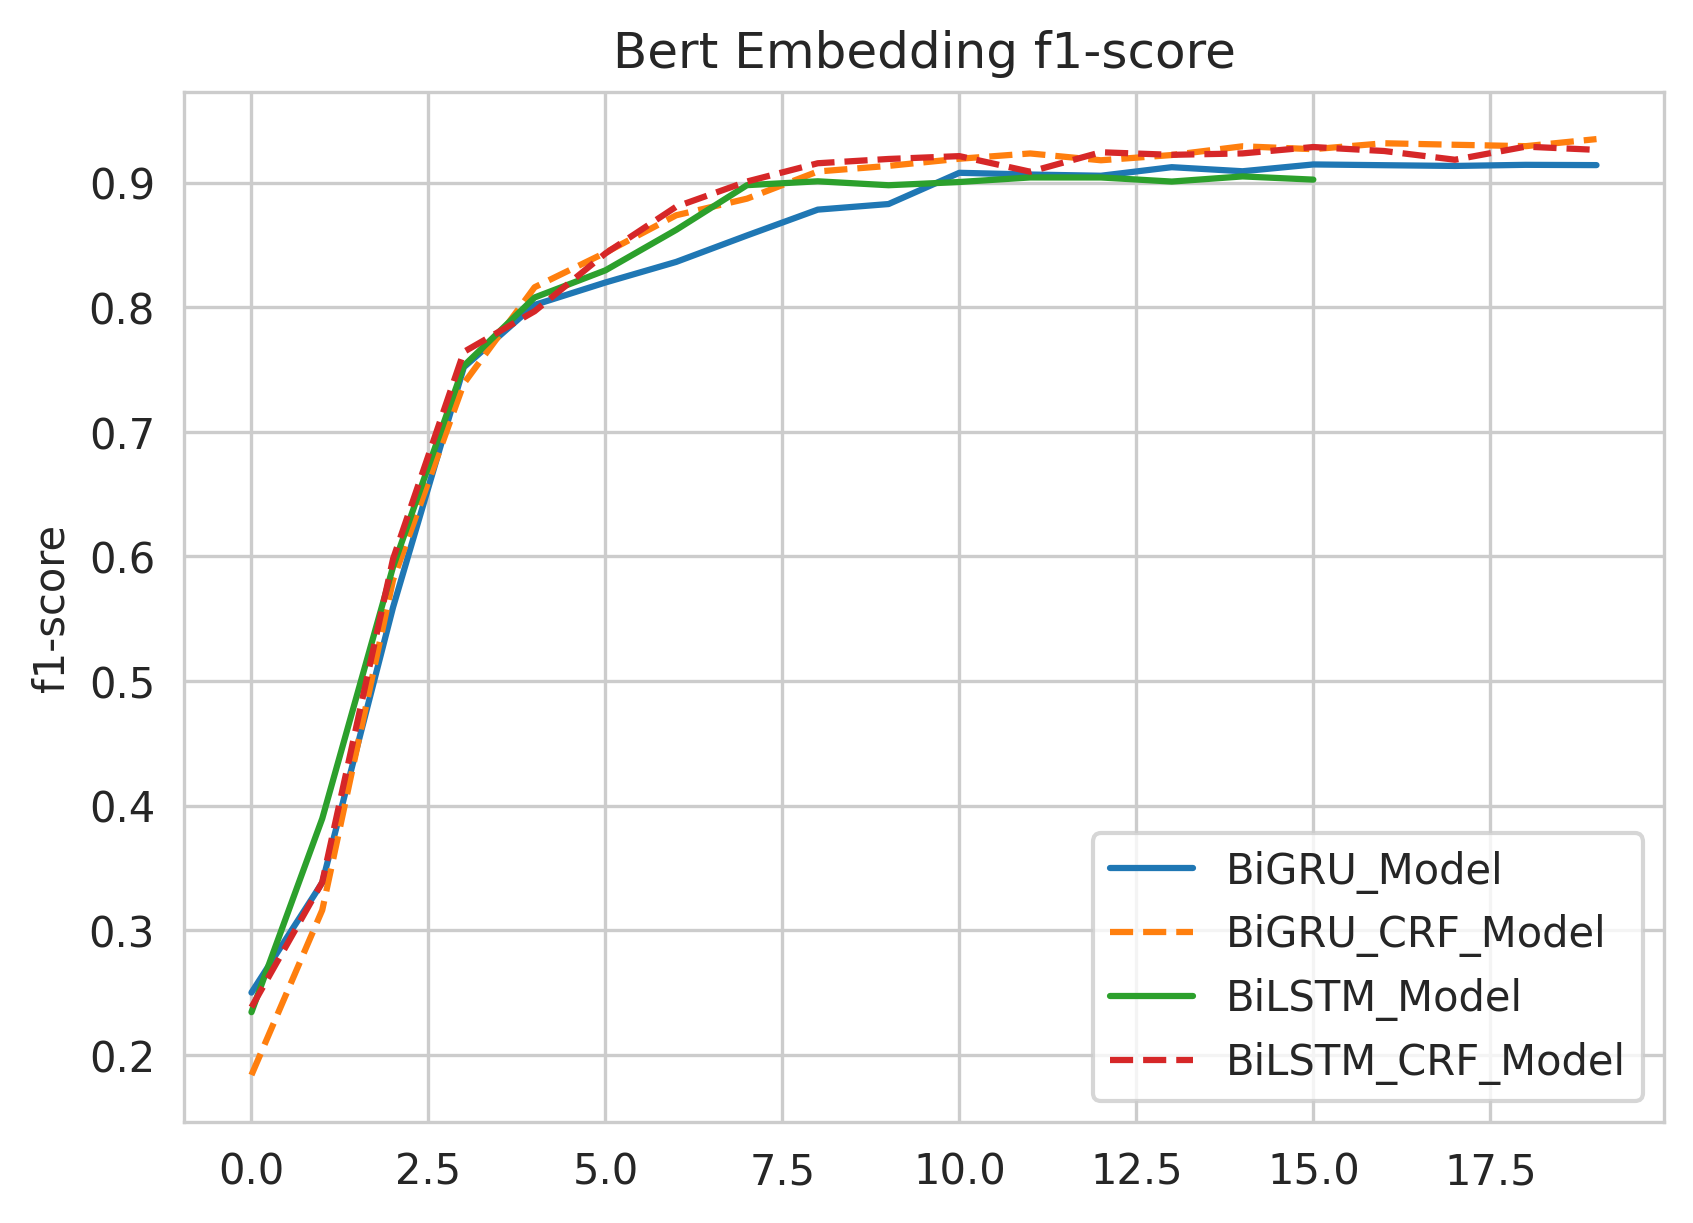


Start Bert_CNN_LSTM_Model


Preparing text vocab dict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:00<00:00, 106191.22it/s]
2022-10-01 03:56:01,611 [DEBUG] kashgari - --- Build vocab dict finished, Total: 899 ---
2022-10-01 03:56:01,611 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '，', '1', '2', '车', '0', '道']
Preparing text vocab dict: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:00<00:00, 120785.07it/s]
2022-10-01 03:56:01,632 [DEBUG] kashgari - --- Build vocab dict finished, Total: 41 ---
2022-10-01 03:56:01,633 [DEBUG] kashgari - Top-10: ['[PAD]', 'O', 'M-Time', 'M-Direction', 'M-RoadSection', 'M-Expressway', 'M-StakeNumber', 'M-Station', 'M-ExpresswayCode', 'B-Expressway']
2022-10-01 03:56:02,679 [DEBUG] kashgari - fit input shape: (2, 64,

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.6588

2022-10-01 03:58:10,365 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 03:58:43,617 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 03:58:43,618 [DEBUG] kashgari - predict output argmax: [[ 0 13  8 ...  0  0  0]
 [ 0 13  8 ...  0  0  0]
 [ 0 13  8 ...  0  0  0]
 ...
 [ 0  9  5 ...  0  0  0]
 [ 0 13  8 ...  0  0  0]
 [ 0 13 12 ...  0  0  0]]



                precision    recall  f1-score   support

ExpresswayCode     0.0376    0.0787    0.0509       432
    Expressway     0.8196    0.9839    0.8942       434
       Station     0.0265    0.0516    0.0350       310
     Direction     0.3591    0.5618    0.4382       372
   StakeNumber     0.0108    0.0211    0.0143       284
        Tunnel     0.0000    0.0000    0.0000        92
   RoadSection     0.0031    0.0072    0.0043       139
   ServiceArea     0.0000    0.0000    0.0000        49
          Time     0.0297    0.1056    0.0463       161
       Flyover     0.0000    0.0000    0.0000         8
   Interchange     0.0000    0.0000    0.0000        10
           Hub     0.0000    0.0000    0.0000        11
          Ramp     0.0000    0.0000    0.0000         4

     micro avg     0.1743    0.3079    0.2226      2306
     macro avg     0.2264    0.3079    0.2585      2306


epoch: 0 precision: 0.226374, recall: 0.307892, f1-score: 0.258479
18/18 [=========================

2022-10-01 04:00:32,501 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:01:02,753 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:01:02,754 [DEBUG] kashgari - predict output argmax: [[ 0 13  8 ...  8  8  8]
 [ 0 13  8 ...  8  8  8]
 [ 0 13  8 ...  8  8  8]
 ...
 [ 0  9  5 ...  8  8  8]
 [ 0 11  8 ...  8  8  8]
 [ 0 11  8 ...  8  8  8]]



                precision    recall  f1-score   support

ExpresswayCode     0.1200    0.1319    0.1257       432
    Expressway     0.9266    0.9885    0.9565       434
       Station     0.2594    0.3774    0.3075       310
     Direction     0.4877    0.6371    0.5524       372
   StakeNumber     0.1028    0.2183    0.1398       284
        Tunnel     0.0635    0.0870    0.0734        92
   RoadSection     0.0147    0.0791    0.0248       139
   ServiceArea     0.0000    0.0000    0.0000        49
          Time     0.2040    0.7019    0.3161       161
       Flyover     0.0000    0.0000    0.0000         8
   Interchange     0.0000    0.0000    0.0000        10
           Hub     0.0000    0.0000    0.0000        11
          Ramp     0.0000    0.0000    0.0000         4

     micro avg     0.2595    0.4484    0.3288      2306
     macro avg     0.3407    0.4484    0.3777      2306


epoch: 1 precision: 0.340729, recall: 0.448395, f1-score: 0.377731
18/18 [=========================

2022-10-01 04:02:51,830 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:03:22,004 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:03:22,005 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 19 19 19]
 [ 0 11  8 ... 19 19 19]
 [ 0 11  8 ... 19 19 19]
 ...
 [ 0  9  5 ... 19 19 19]
 [ 0 11  8 ... 19 19 19]
 [ 0 11  8 ... 19 19 19]]



                precision    recall  f1-score   support

ExpresswayCode     0.6145    0.6458    0.6298       432
    Expressway     0.9432    0.9954    0.9686       434
       Station     0.5193    0.6935    0.5939       310
     Direction     0.7230    0.8280    0.7719       372
   StakeNumber     0.2777    0.6092    0.3815       284
        Tunnel     0.3913    0.4891    0.4348        92
   RoadSection     0.0244    0.0935    0.0387       139
   ServiceArea     0.0000    0.0000    0.0000        49
          Time     0.4606    0.9441    0.6191       161
       Flyover     0.0000    0.0000    0.0000         8
   Interchange     0.1333    0.2000    0.1600        10
           Hub     0.0000    0.0000    0.0000        11
          Ramp     0.0000    0.0000    0.0000         4

     micro avg     0.4695    0.7021    0.5627      2306
     macro avg     0.5631    0.7021    0.6152      2306


epoch: 2 precision: 0.563112, recall: 0.702082, f1-score: 0.615231
18/18 [=========================

2022-10-01 04:05:10,826 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:05:40,936 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:05:40,937 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 ...
 [ 0  9  5 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]]



                precision    recall  f1-score   support

ExpresswayCode     0.8655    0.8935    0.8793       432
    Expressway     0.9579    0.9954    0.9763       434
       Station     0.6914    0.9032    0.7832       310
     Direction     0.8124    0.9194    0.8625       372
   StakeNumber     0.3971    0.6725    0.4993       284
        Tunnel     0.5333    0.6957    0.6038        92
   RoadSection     0.0518    0.1223    0.0728       139
   ServiceArea     0.0536    0.0612    0.0571        49
          Time     0.7248    0.9814    0.8338       161
       Flyover     0.0000    0.0000    0.0000         8
   Interchange     0.2941    0.5000    0.3704        10
           Hub     0.0000    0.0000    0.0000        11
          Ramp     0.1000    0.2500    0.1429         4

     micro avg     0.6312    0.8148    0.7113      2306
     macro avg     0.6929    0.8148    0.7441      2306


epoch: 3 precision: 0.692894, recall: 0.814831, f1-score: 0.744148
18/18 [=========================

2022-10-01 04:07:29,910 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:08:00,036 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:08:00,037 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 ...
 [ 0  9  5 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]]



                precision    recall  f1-score   support

ExpresswayCode     0.9009    0.9259    0.9132       432
    Expressway     0.9643    0.9954    0.9796       434
       Station     0.7821    0.9032    0.8383       310
     Direction     0.8747    0.9382    0.9053       372
   StakeNumber     0.4749    0.6655    0.5543       284
        Tunnel     0.5630    0.7283    0.6351        92
   RoadSection     0.0752    0.1439    0.0988       139
   ServiceArea     0.5333    0.6531    0.5872        49
          Time     0.8421    0.9938    0.9117       161
       Flyover     0.1111    0.1250    0.1176         8
   Interchange     0.2941    0.5000    0.3704        10
           Hub     0.0000    0.0000    0.0000        11
          Ramp     0.1000    0.2500    0.1429         4

     micro avg     0.7094    0.8395    0.7690      2306
     macro avg     0.7539    0.8395    0.7921      2306


epoch: 4 precision: 0.753941, recall: 0.839549, f1-score: 0.792130
18/18 [=========================

2022-10-01 04:09:49,360 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:10:19,464 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:10:19,465 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 ...
 [ 0  9  5 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]
 [ 0 11  8 ...  4  4  4]]



                precision    recall  f1-score   support

ExpresswayCode     0.9233    0.9468    0.9349       432
    Expressway     0.9730    0.9977    0.9852       434
       Station     0.8295    0.9419    0.8822       310
     Direction     0.8759    0.9489    0.9110       372
   StakeNumber     0.5195    0.7042    0.5979       284
        Tunnel     0.6372    0.7826    0.7024        92
   RoadSection     0.1181    0.2014    0.1489       139
   ServiceArea     0.6984    0.8980    0.7857        49
          Time     0.9249    0.9938    0.9581       161
       Flyover     0.2222    0.2500    0.2353         8
   Interchange     0.5333    0.8000    0.6400        10
           Hub     0.2727    0.2727    0.2727        11
          Ramp     0.1111    0.2500    0.1538         4

     micro avg     0.7543    0.8695    0.8078      2306
     macro avg     0.7894    0.8695    0.8255      2306


epoch: 5 precision: 0.789419, recall: 0.869471, f1-score: 0.825488
18/18 [=========================

2022-10-01 04:12:08,439 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:12:38,603 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:12:38,604 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9550    0.9815    0.9680       432
    Expressway     0.9819    0.9977    0.9897       434
       Station     0.8468    0.9452    0.8933       310
     Direction     0.8930    0.9651    0.9276       372
   StakeNumber     0.5797    0.7042    0.6359       284
        Tunnel     0.6786    0.8261    0.7451        92
   RoadSection     0.1747    0.2878    0.2174       139
   ServiceArea     0.7857    0.8980    0.8381        49
          Time     0.9302    0.9938    0.9610       161
       Flyover     0.2222    0.2500    0.2353         8
   Interchange     0.7273    0.8000    0.7619        10
           Hub     0.6364    0.6364    0.6364        11
          Ramp     0.2222    0.5000    0.3077         4

     micro avg     0.7917    0.8881    0.8371      2306
     macro avg     0.8196    0.8881    0.8511      2306


epoch: 6 precision: 0.819577, recall: 0.888118, f1-score: 0.851092
18/18 [=========================

2022-10-01 04:14:27,507 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:14:57,602 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:14:57,603 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9502    0.9722    0.9611       432
    Expressway     0.9709    1.0000    0.9852       434
       Station     0.8596    0.9484    0.9018       310
     Direction     0.8738    0.9489    0.9098       372
   StakeNumber     0.5960    0.7430    0.6614       284
        Tunnel     0.7182    0.8587    0.7822        92
   RoadSection     0.1762    0.2878    0.2186       139
   ServiceArea     0.7258    0.9184    0.8108        49
          Time     0.9302    0.9938    0.9610       161
       Flyover     0.4444    0.5000    0.4706         8
   Interchange     0.8000    0.8000    0.8000        10
           Hub     0.8333    0.9091    0.8696        11
          Ramp     0.2500    0.5000    0.3333         4

     micro avg     0.7926    0.8933    0.8400      2306
     macro avg     0.8197    0.8933    0.8535      2306


epoch: 7 precision: 0.819733, recall: 0.893322, f1-score: 0.853471
18/18 [=========================

2022-10-01 04:16:47,108 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:17:17,243 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:17:17,245 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9593    0.9815    0.9703       432
    Expressway     0.9796    0.9977    0.9886       434
       Station     0.8724    0.9484    0.9088       310
     Direction     0.8815    0.9597    0.9189       372
   StakeNumber     0.6407    0.7535    0.6926       284
        Tunnel     0.7714    0.8804    0.8223        92
   RoadSection     0.2110    0.3309    0.2577       139
   ServiceArea     0.7077    0.9388    0.8070        49
          Time     0.9302    0.9938    0.9610       161
       Flyover     0.4000    0.5000    0.4444         8
   Interchange     0.8000    0.8000    0.8000        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.3333    0.7500    0.4615         4

     micro avg     0.8129    0.9024    0.8553      2306
     macro avg     0.8362    0.9024    0.8667      2306


epoch: 8 precision: 0.836153, recall: 0.902428, f1-score: 0.866689
18/18 [=========================

2022-10-01 04:19:06,698 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:19:36,746 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:19:36,747 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9593    0.9815    0.9703       432
    Expressway     0.9753    1.0000    0.9875       434
       Station     0.8468    0.9452    0.8933       310
     Direction     0.8701    0.9543    0.9103       372
   StakeNumber     0.7474    0.7500    0.7487       284
        Tunnel     0.7961    0.8913    0.8410        92
   RoadSection     0.4170    0.6691    0.5138       139
   ServiceArea     0.7797    0.9388    0.8519        49
          Time     0.9412    0.9938    0.9668       161
       Flyover     0.4000    0.5000    0.4444         8
   Interchange     0.8000    0.8000    0.8000        10
           Hub     0.8333    0.9091    0.8696        11
          Ramp     0.3333    0.7500    0.4615         4

     micro avg     0.8426    0.9215    0.8803      2306
     macro avg     0.8581    0.9215    0.8868      2306


epoch: 9 precision: 0.858095, recall: 0.921509, f1-score: 0.886830
18/18 [=========================

2022-10-01 04:21:26,294 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:21:56,325 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:21:56,326 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9593    0.9815    0.9703       432
    Expressway     0.9753    1.0000    0.9875       434
       Station     0.8780    0.9516    0.9133       310
     Direction     0.8997    0.9651    0.9313       372
   StakeNumber     0.8589    0.7500    0.8008       284
        Tunnel     0.7981    0.9022    0.8469        92
   RoadSection     0.5640    0.8561    0.6800       139
   ServiceArea     0.7188    0.9388    0.8142        49
          Time     0.9412    0.9938    0.9668       161
       Flyover     0.5000    0.6250    0.5556         8
   Interchange     0.8000    0.8000    0.8000        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.3000    0.7500    0.4286         4

     micro avg     0.8780    0.9367    0.9064      2306
     macro avg     0.8895    0.9367    0.9097      2306


epoch: 10 precision: 0.889524, recall: 0.936687, f1-score: 0.909725
18/18 [========================

2022-10-01 04:23:45,474 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:24:15,481 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:24:15,482 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9615    0.9838    0.9725       432
    Expressway     0.9797    1.0000    0.9897       434
       Station     0.8852    0.9452    0.9142       310
     Direction     0.8903    0.9597    0.9237       372
   StakeNumber     0.8543    0.7641    0.8067       284
        Tunnel     0.8155    0.9130    0.8615        92
   RoadSection     0.5505    0.8633    0.6723       139
   ServiceArea     0.7188    0.9388    0.8142        49
          Time     0.9412    0.9938    0.9668       161
       Flyover     0.4545    0.6250    0.5263         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.3000    0.7500    0.4286         4

     micro avg     0.8771    0.9380    0.9065      2306
     macro avg     0.8903    0.9380    0.9106      2306


epoch: 11 precision: 0.890251, recall: 0.937988, f1-score: 0.910605
18/18 [========================

2022-10-01 04:26:04,498 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:26:34,465 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:26:34,466 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9615    0.9838    0.9725       432
    Expressway     0.9775    1.0000    0.9886       434
       Station     0.8825    0.9452    0.9128       310
     Direction     0.8908    0.9651    0.9265       372
   StakeNumber     0.8760    0.7711    0.8202       284
        Tunnel     0.7981    0.9022    0.8469        92
   RoadSection     0.5681    0.8705    0.6875       139
   ServiceArea     0.7188    0.9388    0.8142        49
          Time     0.9467    0.9938    0.9697       161
       Flyover     0.2222    0.2500    0.2353         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8815    0.9384    0.9091      2306
     macro avg     0.8925    0.9384    0.9121      2306


epoch: 12 precision: 0.892529, recall: 0.938422, f1-score: 0.912144
18/18 [========================

2022-10-01 04:28:23,572 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:28:53,514 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:28:53,515 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9864    1.0000    0.9931       434
       Station     0.8981    0.9387    0.9180       310
     Direction     0.8859    0.9597    0.9213       372
   StakeNumber     0.8811    0.7570    0.8144       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5556    0.8633    0.6761       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9581    0.9938    0.9756       161
       Flyover     0.4286    0.3750    0.4000         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8880    0.9350    0.9109      2306
     macro avg     0.8989    0.9350    0.9137      2306


epoch: 13 precision: 0.898948, recall: 0.934952, f1-score: 0.913705
18/18 [========================

2022-10-01 04:30:42,662 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:31:12,665 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:31:12,666 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9864    1.0000    0.9931       434
       Station     0.8923    0.9355    0.9134       310
     Direction     0.8930    0.9651    0.9276       372
   StakeNumber     0.8811    0.7570    0.8144       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5251    0.8273    0.6425       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9639    0.9938    0.9786       161
       Flyover     0.3000    0.3750    0.3333         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8845    0.9332    0.9082      2306
     macro avg     0.8974    0.9332    0.9121      2306


epoch: 14 precision: 0.897443, recall: 0.933218, f1-score: 0.912065
18/18 [========================

2022-10-01 04:33:01,753 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:33:31,653 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:33:31,654 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9864    1.0000    0.9931       434
       Station     0.8954    0.9387    0.9165       310
     Direction     0.8953    0.9651    0.9288       372
   StakeNumber     0.8811    0.7570    0.8144       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5488    0.8489    0.6667       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9639    0.9938    0.9786       161
       Flyover     0.2727    0.3750    0.3158         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8876    0.9350    0.9107      2306
     macro avg     0.8996    0.9350    0.9141      2306


epoch: 15 precision: 0.899551, recall: 0.934952, f1-score: 0.914081
18/18 [========================

2022-10-01 04:35:20,782 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:35:50,671 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:35:50,672 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9864    1.0000    0.9931       434
       Station     0.8954    0.9387    0.9165       310
     Direction     0.8997    0.9651    0.9313       372
   StakeNumber     0.8848    0.7570    0.8159       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5561    0.8561    0.6742       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9639    0.9938    0.9786       161
       Flyover     0.3000    0.3750    0.3333         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8899    0.9354    0.9121      2306
     macro avg     0.9013    0.9354    0.9152      2306


epoch: 16 precision: 0.901253, recall: 0.935386, f1-score: 0.915176
18/18 [========================

2022-10-01 04:37:40,331 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:38:10,203 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:38:10,204 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9864    1.0000    0.9931       434
       Station     0.8954    0.9387    0.9165       310
     Direction     0.8975    0.9651    0.9301       372
   StakeNumber     0.8811    0.7570    0.8144       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5540    0.8489    0.6705       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9639    0.9938    0.9786       161
       Flyover     0.2727    0.3750    0.3158         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8887    0.9350    0.9112      2306
     macro avg     0.9002    0.9350    0.9145      2306


epoch: 17 precision: 0.900223, recall: 0.934952, f1-score: 0.914503
18/18 [========================

2022-10-01 04:39:59,427 [DEBUG] kashgari - predict seq_length: 150, input: (2, 426, 150)


2/2 [==============================] - 12s 6s/step


2022-10-01 04:40:29,383 [DEBUG] kashgari - predict output: (426, 150)
2022-10-01 04:40:29,384 [DEBUG] kashgari - predict output argmax: [[ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 ...
 [ 0  9  5 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]
 [ 0 11  8 ... 18 18 18]]



                precision    recall  f1-score   support

ExpresswayCode     0.9571    0.9815    0.9691       432
    Expressway     0.9886    1.0000    0.9943       434
       Station     0.8954    0.9387    0.9165       310
     Direction     0.8997    0.9651    0.9313       372
   StakeNumber     0.8710    0.7606    0.8120       284
        Tunnel     0.8235    0.9130    0.8660        92
   RoadSection     0.5509    0.8561    0.6704       139
   ServiceArea     0.8070    0.9388    0.8679        49
          Time     0.9639    0.9938    0.9786       161
       Flyover     0.3000    0.3750    0.3333         8
   Interchange     1.0000    0.8000    0.8889        10
           Hub     1.0000    1.0000    1.0000        11
          Ramp     0.5000    0.7500    0.6000         4

     micro avg     0.8881    0.9358    0.9113      2306
     macro avg     0.8997    0.9358    0.9147      2306


epoch: 18 precision: 0.899665, recall: 0.935820, f1-score: 0.914679
18/18 [========================

2022-10-01 04:40:30,332 [INFO] kashgari - model saved to /home/administrator/PycharmProjects/Expressway_extract/controlled_experiment/BiLSTM-CRF/model_folder/BertCNN_LSTM_Model


In [17]:
for embed_name, embed in embeddings:
        for model_name, MOEDL_CLASS in model_classes:
            run_name = f"{embed_name}_{model_name}"
            if os.path.exists(LOG_FILE_PATH):
                logs = json.load(open(LOG_FILE_PATH, 'r'))
            else:
                logs = {}
            if logs:
                display.clear_output(wait=True)
                show_plot(logs)

            if embed_name in logs and model_name in logs[embed_name]:
                print(f"Skip {run_name}, already finished")
                continue
            print('=' * 50)
            print(f"\nStart {run_name}")
            print('=' * 50)
            model = MOEDL_CLASS(embed, sequence_length=SEQUENCE_LENGTH)

            early_stop = keras.callbacks.EarlyStopping(patience=EARL_STOPPING_PATIENCE)
            reduse_lr_callback = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                                   patience=REDUCE_RL_PATIENCE)
            eval_callback = EvalCallBack(kash_model=model,
                                         x_data=valid_x,
                                         y_data=valid_y,
                                         truncating=True,
                                         step=1)

            tf_board = keras.callbacks.TensorBoard(
                log_dir=os.path.join(TF_LOG_FOLDER, run_name),
                update_freq='epoch'
            )

            callbacks = [early_stop, reduse_lr_callback, eval_callback, tf_board]

            model.fit(train_x,
                      train_y,
                      valid_x,
                      valid_y,
                      callbacks=callbacks,
                      epochs=EPOCHS)

            if embed_name not in logs:
                logs[embed_name] = {}

            logs[embed_name][model_name] = eval_callback.logs

            with open(LOG_FILE_PATH, 'w') as f:
                f.write(json.dumps(logs, indent=2))
            model.save(os.path.join(MODEL_FOLDER, embed_name + model_name))


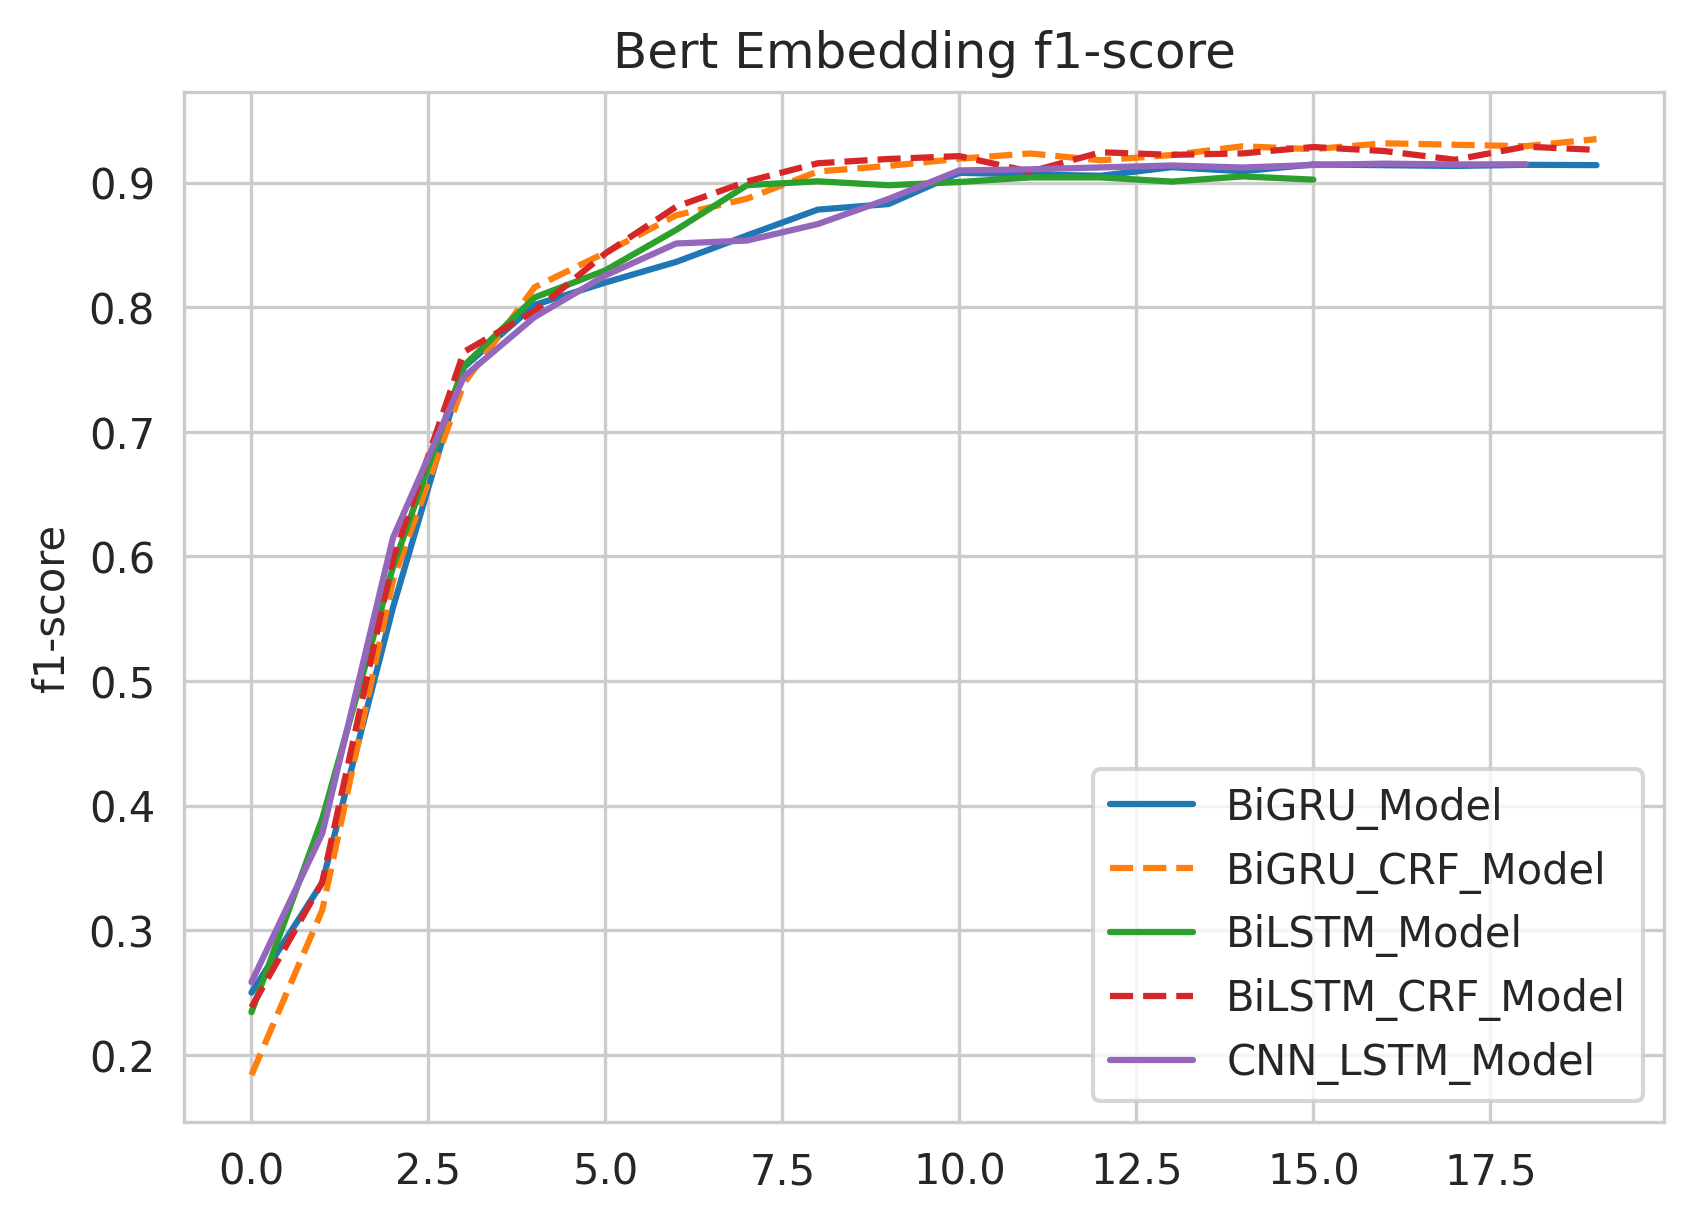

,Embedding,Model,Best F1-Score,Best F1 @ epochs
0,Bert,BiGRU_Model,91.45,15
1,Bert,BiGRU_CRF_Model,93.49,19
2,Bert,BiLSTM_Model,90.49,14
3,Bert,BiLSTM_CRF_Model,92.88,18
4,Bert,CNN_LSTM_Model,91.52,16


In [18]:
with open(LOG_FILE_PATH, 'r') as f:
    full_data = json.loads(f.read())
# Re-orded embedings by the easy way
new_full_data = {
#     'RoBERTa-wwm-ext': full_data['RoBERTa-wwm-ext'],
#     'Bert-Chinese': full_data['Bert-Chinese'],
    'Bert': full_data['Bert']
}
full_data = new_full_data 
show_plot(full_data)


import pandas as pd
pd_data = []
for embed, models in full_data.items():
    for model_name, epochs in models.items():
        max_score = 0
        max_epoch = 0
        for epoch_index, epoch_data in enumerate(epochs):
            if epoch_data['f1-score'] > max_score:
                max_score = epoch_data['f1-score'] 
                max_epoch = epoch_index
        pd_data.append({
            'Embedding': embed,
            'Model': model_name,
            'Best F1-Score': round(max_score*100, 2),
            'Best F1 @ epochs': max_epoch
        })
df = pd.DataFrame(pd_data)
df

In [19]:
full_data

{'Bert': {'BiGRU_Model': [{'precision': 0.2174420113309395,
    'recall': 0.30138768430182133,
    'f1-score': 0.25009925688952095},
   {'precision': 0.3091829765991516,
    'recall': 0.3950563746747615,
    'f1-score': 0.3383215129997458},
   {'precision': 0.5198220614355472,
    'recall': 0.6235906331309627,
    'f1-score': 0.5592027458877369},
   {'precision': 0.7183218425836815,
    'recall': 0.7944492627927147,
    'f1-score': 0.7518433642370027},
   {'precision': 0.7701761137237989,
    'recall': 0.8404163052905465,
    'f1-score': 0.8018103694794022},
   {'precision': 0.7903867864193247,
    'recall': 0.8555941023417173,
    'f1-score': 0.8198129831699369},
   {'precision': 0.8084939125069008,
    'recall': 0.8699045967042498,
    'f1-score': 0.8363338020783964},
   {'precision': 0.8343025230993956,
    'recall': 0.8850823937554206,
    'f1-score': 0.8575577794475917},
   {'precision': 0.8605148257758005,
    'recall': 0.9006938421509106,
    'f1-score': 0.8782685139270375},
   